In [1]:
import pandas as pd
import numpy as np
import math
import sqlite3
import sys 
sys.path.append(r'/Users/asbjornfyhn/Desktop/Python')
from functions import plotgenerator as pg
from scipy.optimize import minimize

#
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
import time

In [2]:
#Connecting to the database
tidy_finance = sqlite3.connect(
    database=f"/Users/asbjornfyhn/Desktop/Emp Fin/data/tidy_finance_python.sqlite"
)

#Reading in crsp_monthly dataset
crsp_monthly = (pd.read_sql_query(
    sql="SELECT permno, month, ret_excess FROM crsp_monthly",
    con=tidy_finance,
    parse_dates={"month"})
)

#Dropping all stocks before 1962
crsp_monthly = crsp_monthly.query("month >= '1962-01-01'")

#Dropping all stocks after 2020
crsp_monthly = crsp_monthly.query("month < '2021-01-01'")

#Dropping all stocks with missing values
no_of_obs_per_permno = crsp_monthly.month.unique().shape[0]
crsp_monthly = crsp_monthly.groupby("permno").filter(lambda x: x.shape[0] == no_of_obs_per_permno)

We continue with the dataset from previous exercise which contains 600 months of returns for each of the 119 companies. 

The objective of the exercise is to backtest three different portfolios and compare their performance.
The portfolios are:
1. Naive portfolio: weights are equal for all companies. 
2. Mean-variance portfolio: weights are determined by the mean-variance optimization with a no-short-selling constraint.
3. Hautsch et al. portoflio: weights are theoretically optimal with ex-ante adjustment for transaction costs.

For portfolio 1. the weights are calculated as 

$w_i = 1/N, \: \forall i=1,2,...,N$ 

where $N$ is the number of companies.

For portfolio 2. the weights are calculated as

$
w = \arg \min \frac{1}{2} w' \hat{\Sigma} w \:\: \text{s.t.} \\
\sum_{i=0}^N w_i = 1 \\
w_i \geq 0, \: \forall i=1,2,...,N
$

where $\hat{\Sigma}$ is some estimated covariance matrix of returns. The estimator for the covariance matrix will be explained later.

For portfolio 3. the weights are calculated as explained in the previous exercise.

Throughout the exercise we will use a transaction cost of 200*bp* and risk-aversion of $\gamma=4$.

Returning to the estimator of returns vector $\mu$ and the covariance matrix $\Sigma$. We use a rather simple sample average of past returns as our estimator for the returns while we will use the Ledoit-Wolf shrinkage estimator which is given by:

$\hat{\Sigma} = \alpha \hat{\Sigma}_{\text{target}} + (1-\alpha) \hat{\Sigma}_{\text{sample}}$

where $alpha$ is our linear shrinkage parameter, $\hat{\Sigma}_{\text{target}}$ is the target matrix and $\hat{\Sigma}_{\text{sample}}$ is the sample covariance matrix. 
The target matrix is given by:

$
\hat{\Sigma}_{\text{target}} = I_N (\frac{1}{N} \sum_{i=1}^N var(r_{it}))
$

where $I_N$ is the identity matrix of size $N \times N$ and $var(r_{it})$ is the variance of the returns of company $i$.
The linear shrinkage parameter is given by:

$
\alpha = \frac{\hat{\pi}}{\hat{\gamma}}
$
where $\hat{\pi}$ is the average pairwise sample covariance and $\hat{\gamma}$ is Frobenuis norm of the matrix $\hat{\Sigma}_{\text{sample}} - \hat{\Sigma}_{\text{target}}$.

In our backtest, we slice the dataset into 600 months of accessible data and 120 months of data which we use as out-of-sample data for testing the performance for each portfolio. We choose to test our portfolios on the last 120 months of data taking computation time into account and at the same time we want to have a reasonable amount of data to test the performance of the portfolios. 

We assume that the portfolios are equally weighted and thus equal to the naive portfolio - only playing a role for portfolio 3 which takes the transaction cost of moving from one portfolio to another into account. Coming into 2011 (starting period), the optimal portfolios are created on based on the estimates of $\hat{\Sigma}$ and $\hat{\mu}$ which are estimated on all available data up to the period. After having the optimal portfolios, we use the returns of the current month to calculate the performance of the portfolios. Likewise in the following month, the portfolio weigths are updated using the new estimates of $\hat{\Sigma}$ and $\hat{\mu}$. This procedure is repeated until the end of dataset. 

Our backtest strategy only uses the data that is available at the time of the portfolio creation. This means that we do not use any future data to estimate the optimal portfolios, and therefor no look-ahead bias is present in our backtest. This makes our backtest realistic and reliable. However, the dataset which we use to test is obviously not true out-of-sample data and the results will be biased based on the chosen period of testing. For instance, should the drawdown of the market around the Great-Financial Crisis be in the testing period or not, and thus could certain portfolios be favored over others based on the testing period. Alternatively, we could generate a dataset from random drawings based on our estimated $\hat{\Sigma}$ and $\hat{\mu}$ and use this as out-of-sample data. This type of backtest would be more robust to the choice of testing period. However, it would be based on estimator of $\hat{\Sigma}$ and $\hat{\mu}$ which are not the true values and thus not resembling true data.



In [3]:
def expected_returns(data: pd.DataFrame)->np.ndarray:
    """
    This function estimates the expected returns for each stock in the crsp_monthly dataset
    """
    return crsp_monthly.groupby("permno").ret_excess.mean().values


In [4]:
# Estimate the covariance matrix
def cov1Para(Y,k = None):
    """
    This function estimates the covariance matrix for the stocks in the crsp_monthly dataset
    """
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned

    # de-mean returns if required
    N,p = Y.shape                      # sample size and matrix dimension
   
    #default setting
    if k is None or math.isnan(k):
        mean = Y.mean(axis=0)
        Y = Y.sub(mean, axis=1)                               #demean
        k = 1
    #vars
    n = N-k                                    # adjust effective sample size
    
    
    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
    
    # compute shrinkage target
    diag = np.diag(sample.to_numpy())
    meanvar= sum(diag)/len(diag)
    target=meanvar*np.eye(p)
    
    # estimate the parameter that we call pi in Ledoit and Wolf (2003, JEF)
    Y2 = pd.DataFrame(np.multiply(Y.to_numpy(),Y.to_numpy()))
    sample2= pd.DataFrame(np.matmul(Y2.T.to_numpy(),Y2.to_numpy()))/n     # sample covariance matrix of squared returns
    piMat=pd.DataFrame(sample2.to_numpy()-np.multiply(sample.to_numpy(),sample.to_numpy()))
    

    pihat = sum(piMat.sum())
    
    # estimate the parameter that we call gamma in Ledoit and Wolf (2003, JEF)
    gammahat = np.linalg.norm(sample.to_numpy()-target,ord = 'fro')**2
    
    # compute shrinkage intensity
    kappahat=pihat/gammahat
    shrinkage=max(0,min(1,kappahat/n))
    
    # compute shrinkage estimator
    sigmahat=shrinkage*target+(1-shrinkage)*sample
    
    return sigmahat

def covariance_matrix(crsp_monthly, linear_shrinkage = False):
    """
    This function estimates the covariance matrix for the stocks in the crsp_monthly dataset
    """
    dataframe = crsp_monthly.pivot(index="month", columns="permno", values="ret_excess")
    if linear_shrinkage:
        sigma = cov1Para(dataframe)
    else: 
        sigma = dataframe.cov().values
    return sigma


In [5]:
def compute_naive_portfolio(N):
    """
    This function creates a naive portfolio with N stocks. The portfolio is equally weighted.
    """
    return np.repeat(1/N,N)

In [6]:
# optimization constraints and parameters
def objective_mvp(w, *args):
    sigma = args[0]
    return 0.5*w.T @ sigma @ w
  
def gradient_mvp(w, *args):
    sigma = args[0]
    return sigma @ w

def equality_constraint(w):
    return np.sum(w)-1

def jacobian_equality(w):
    return np.ones_like(w)

constraints = (
  {"type": "eq", "fun": equality_constraint, "jac": jacobian_equality}
)

options = {
  "tol":1e-20,
  "maxiter": 10000,
  "method":"SLSQP"
}

In [7]:
def compute_mean_variance_portfolio(mu, sigma, constraints, options,w_initial):
    """
    This function computes the mean-variance portfolio
    """
    N = mu.shape[0]
    if w_initial is None:
        w_initial = compute_naive_portfolio(N)
    w_mvp = minimize(
        x0=w_initial,
        fun=objective_mvp,
        jac=gradient_mvp,
        args=(sigma),
        bounds=((0, None), )*N,
        constraints=constraints,
        tol=options["tol"],
        options={"maxiter": options["maxiter"]},
        method=options["method"]
    )
    return w_mvp.x

In [9]:
def adjust_weights(w, next_return):
    """
    This function adjusts the portfolio weights based on the next period's returns.
    """
    w_prev = 1+w*next_return
    w_next = np.array(w_prev/np.sum(np.array(w_prev)))
    return w_next

def evaluate_performance(w, w_previous, next_return, beta=50):
    """Calculate portfolio evaluation measures."""  
    
    raw_return = np.dot(next_return, w)
    turnover = np.sum(np.abs(w-w_previous))
    net_return = raw_return-beta/10000*turnover
    
    return np.array([raw_return, turnover, net_return])

In [18]:
# define legnth of available data and length of backtest period
window_length = 600 
periods = len(crsp_monthly['month'].unique())-window_length

n_assets = len(crsp_monthly['permno'].unique())
# set equal weights for all assets in period t-1
w_prev_1 = w_prev_2 = w_prev_3 = np.ones(n_assets)/n_assets

# define transaction cost and risk aversion
beta = 200
gamma = 4

# initialize performance dictionary to store performance values
performance_values = np.empty((periods, 3)) + np.nan
performance_values = {
  "MV (TC)": performance_values.copy(), 
  "Naive": performance_values.copy(), 
  "MV": performance_values.copy()
}

In [22]:
def compute_efficient_weight(sigma, 
                             mu, 
                             gamma=2, 
                             beta=0,
                             w_prev=None):
    """Compute efficient portfolio weights."""
    
    n = sigma.shape[1]
    iota = np.ones(n)
    if w_prev is None:
        w_prev = np.ones(sigma.shape[1])/sigma.shape[1]
    sigma_processed = sigma+(beta/gamma)*np.eye(n)
    mu_processed = mu+beta*w_prev

    sigma_inverse = np.linalg.inv(sigma_processed)

    w_mvp = sigma_inverse @ iota
    w_mvp = w_mvp/np.sum(w_mvp)
    w_opt = w_mvp+(1/gamma)*\
        (sigma_inverse-np.outer(w_mvp, iota) @ sigma_inverse) @ mu_processed
        
    return w_opt

In [24]:
# sort the values so we can iterate over the data
crsp_monthly.sort_values(["month","permno"], inplace=True)

for p in range(periods):
  # select the available data to estimate the covariance matrix and expected returns
  returns_window = crsp_monthly.groupby('permno', group_keys=False).apply(lambda x: x.iloc[p:(p+window_length-1), :])#.sort_values('permno')
  # select the next period's return -- not avaliable to estimate the portfolio
  next_return = crsp_monthly.groupby('permno', group_keys=False).apply(lambda x: x.iloc[p+window_length, :])['ret_excess']

  # estimate the covariance matrix and expected returns
  sigma_window = covariance_matrix(returns_window, linear_shrinkage=True)
  mu_window = expected_returns(returns_window, ml_model=False)
  #######################################
  # Transaction-cost adjusted portfolio
  w_1 = compute_efficient_weight(
    sigma=sigma_window,
    mu=mu_window,  
    beta=beta, 
    gamma=gamma, 
    w_prev=w_prev_1
  )#.iloc[0,:].values

  # Evaluate performance of the portfolio
  performance_values["MV (TC)"][p,:] = evaluate_performance(w_1, w_prev_1, next_return, beta=beta) 
  # Update the portfolio weights
  w_prev_1 = adjust_weights(w_1, next_return) 

  #######################################
  # Naive portfolio
  w_2 = compute_naive_portfolio(n_assets)
  # Evaluate performance of the portfolio
  performance_values["Naive"][p, :] = evaluate_performance(w_2, w_prev_2, next_return)
  # Update the portfolio weights
  w_prev_2 = adjust_weights(w_2, next_return)

  #######################################
  # Mean-variance efficient portfolio (w/o transaction costs)
  w_3 = compute_mean_variance_portfolio(
    mu=mu_window, 
    sigma=sigma_window, 
    constraints=constraints, 
    options=options,
    w_initial=w_prev_3)
  # Evaluate performance of the portfolio
  performance_values["MV"][p, :] = evaluate_performance(w_3, w_prev_3, next_return)
  # Update the portfolio weights
  w_prev_3 = adjust_weights(w_3, next_return)


In [25]:
# store the performance values in a DataFrame
performance = pd.DataFrame()
for i in enumerate(performance_values.keys()):
    tmp_data = pd.DataFrame(
      performance_values[i[1]], 
      columns=["raw_return", "turnover", "net_return"]
    )
    tmp_data["strategy"] = i[1]
    performance = pd.concat([performance, tmp_data], axis=0)


In [27]:
length_year = 12
# calculate the performance table: mean, standard deviation, Sharpe ratio, and turnover
performance_table = (performance
  .groupby("strategy")
  .aggregate(
    mean=("net_return", lambda x: length_year*100*x.mean()),
    sd=("net_return", lambda x: np.sqrt(length_year)*100*x.std()),
    sharpe_ratio=("net_return", lambda x: (
      (length_year*100*x.mean())/(np.sqrt(length_year)*100*x.std()) 
        if x.mean() > 0 else np.nan)
    ),
    turnover=("turnover", lambda x: 100*x.mean())
  )
  .reset_index()
)


In [36]:
performance_table.rename(columns=
                         {"strategy": "Strategy",
                          "mean": "Mean",
                          "sd": "Standard Deviation",
                          "sharpe_ratio": "Sharpe Ratio",
                          "turnover":"Turnover"}, inplace=True)
# reindex 
performance_table = performance_table.reindex([2,0,1])
performance_table.style.format({
    "Mean": "{:.2f}%",
    "Standard Deviation": "{:.2f}%",
    "Sharpe Ratio": "{:.3}",
    "Turnover": "{:.2f}%"
}).hide(axis='index').set_properties(subset=["Strategy"], **{'text-align': 'left','bold': True})

Strategy,Mean,Standard Deviation,Sharpe Ratio,Turnover
MV,-1.64%,11.51%,nan,160.41%
MV (TC),11.84%,14.62%,0.81,0.12%
Naive,11.87%,14.63%,0.811,0.04%


,strategy,level_1,0
0,MV (TC),raw_return,0.032842
1,MV (TC),turnover,0.001215
2,MV (TC),net_return,0.032817
3,MV (TC),raw_return,0.021340
4,MV (TC),turnover,0.001219
...,...,...,...
967,MV,turnover,1.562311
968,MV,net_return,0.057798
969,MV,raw_return,0.016420
970,MV,turnover,1.564346


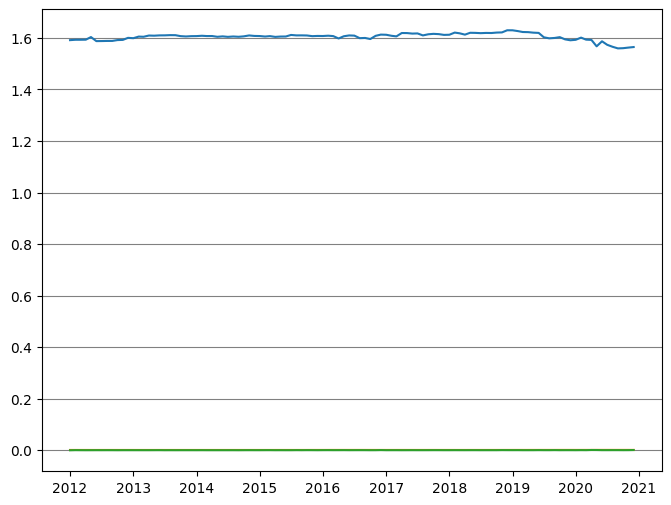

In [64]:
from plotnine import ggplot, aes, facet_grid, labs, geom_point

(
    ggplot(mpg)
    + facet_grid(facets="year~class")
    + aes(x="displ", y="hwy")
    + labs(
        x="Engine Size",
        y="Miles per Gallon",
        title="Miles per Gallon for Each Year and Vehicle Class",
    )
    + geom_point()
)

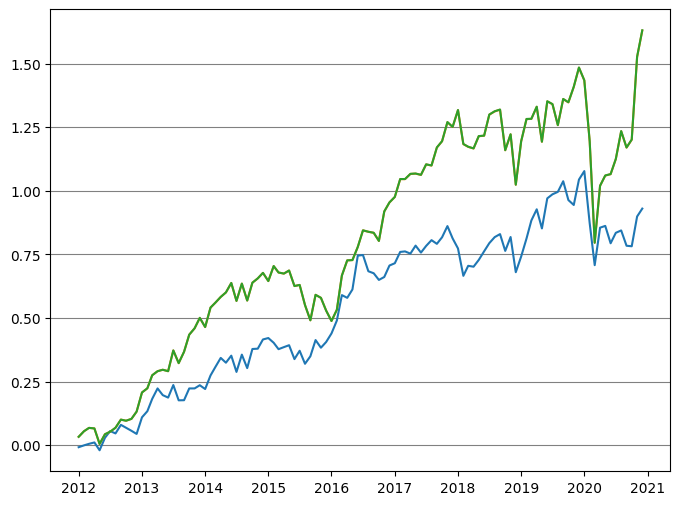

In [62]:
fig = pg.PlotFigure(figsize=(8,6))

fig.add_plot(perf_chart.index,perf_chart['MV'])
fig.add_plot(perf_chart.index,perf_chart['MV (TC)'])
fig.add_plot(perf_chart.index,perf_chart['Naive'])
fig.add_gridlines(axis='y')
fig.show()